# Target Value

Apply the pre-trained object detection model to all MSCOCO data and acquire the follow values:

 - Classification false positive, false negative, true positive
 - Mean Average Precision (mAP)


In [1]:
!pip install torchvision==0.13
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn_v2
import torch
print(torch.__version__)

1.12.0+cu102


In [3]:
model = maskrcnn_resnet50_fpn_v2(weights='COCO_V1')
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [4]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
dataDir='data'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=17.50s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(', '.join(nms)))
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(nms)))

COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush

COCO supercategories: 
kitchen, accessory, person, furniture, outdoor, indoor, electronic, food, sports, vehicle, appliance, animal


In [7]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds);
print(len(imgIds))
imgs = coco.loadImgs(imgIds)

64115


In [8]:
from torchvision import transforms
from torch.autograd import Variable
torch.no_grad()

## Define Config and DataSet

If we load all images into memory directly, the server will crash. (I tried it. It actually does crash.)


1. One way is to design config and dataset as this reference:
 - https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/coco.py
 - And run all images as the test data after training.


2. Another way is to get a smaller set and run it one set by one set.
 - Will need to resize the images before turning them into tensor
 - Might need to resize the BBox back before validating


In [9]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([512, 512])
])

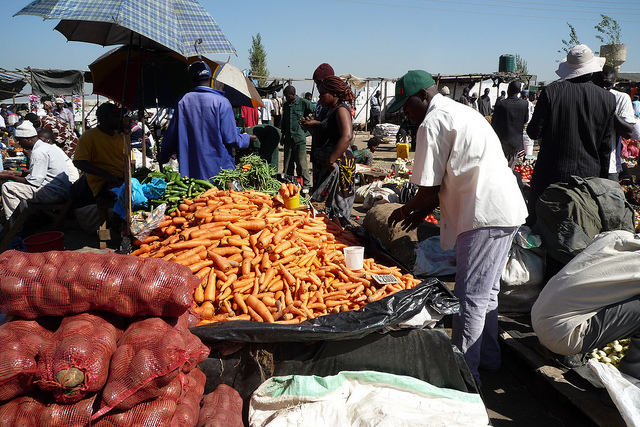

In [10]:
file_name = imgs[0]['file_name']
image = Image.open(f'{dataDir}/images/{dataType}/{file_name}')
image

In [11]:
images = []
i = 0
for img in imgs[:4]:
    i += 1
    if i % 500 == 0:
        print(i)
    file_name = img['file_name']
    try:
        image = Image.open(f'{dataDir}/images/{dataType}/{file_name}')
        imgblob = data_transforms(image)
        imgblob.unsqueeze_(dim=0)
        images.append(imgblob)
    except:
        print(file_name)

In [12]:
print(len(images), images[0].shape)

4 torch.Size([1, 3, 512, 512])


In [13]:
images = torch.cat(images, dim=0)
images.shape

torch.Size([4, 3, 512, 512])

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(device)

0
1
cuda:0


In [15]:
%time
pred = model(images)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 11.2 µs


In [16]:
gimages = images.to(device)
gmodel = model.to(device)

In [17]:
%time
pred = gmodel(gimages)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs


In [18]:
pred[0]

{'boxes': tensor([[309.9775,  82.0505, 426.3796, 458.4083],
         [128.4542,  75.3245, 201.1623, 217.7575],
         [ 10.0072,   0.0000, 193.8114,  76.8283],
         [420.0117,  53.8445, 501.2510, 248.8896],
         [240.8091,  88.2288, 285.4255, 264.1130],
         [392.8888,  95.0321, 424.9928, 199.2882],
         [  0.0000, 148.5817,  62.8323, 275.6091],
         [ 56.8663, 122.8296, 106.4893, 254.7891],
         [ 68.6920,  52.6857, 154.6184, 137.5765],
         [421.2247, 208.2493, 509.8028, 323.4779],
         [222.9383, 102.6707, 251.2587, 222.2367],
         [105.0224, 222.5483, 339.1451, 391.0782],
         [422.9084, 274.5435, 511.4286, 448.7743],
         [274.9930, 294.8982, 291.7878, 323.9659],
         [383.1850, 106.0631, 394.3342, 140.8703],
         [198.6922, 147.5235, 225.2236, 200.4353],
         [474.9494,  76.2693, 511.1270, 173.9162],
         [151.9723,  66.8600, 211.7973, 130.4010],
         [  2.0853, 299.9978, 163.2265, 382.6689],
         [396.8563, 10